# Soft Actor-Critic (SAC) for BipedalWalker-v3

This notebook implements a Soft Actor-Critic (SAC) agent to solve the BipedalWalker-v3 environment from Gymnasium.
SAC is an off-policy actor-critic deep RL algorithm based on the maximum entropy reinforcement learning framework.

In [8]:
# !pip install swig
# !pip install gymnasium[box2d]

import gymnasium as gym
import numpy as np
import cv2  # Added for parallel window rendering
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
from collections import deque
import random
import os
import matplotlib.pyplot as plt
# Change to standard tqdm to avoid notebook widget errors
from tqdm import tqdm

In [9]:
# For local training on Mac, 
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    try:
        torch.cuda.set_device(0)
        gpu_name = torch.cuda.get_device_name(0)
        props = torch.cuda.get_device_properties(0)
        print(f"CUDA GPU: {gpu_name} | Memory: {props.total_memory/1024**3:.1f} GB")
    except Exception as e:
        print(f"GPU info not available: {e}")

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True

set_seed(42)

Using device: mps


## Replay Buffer

The replay buffer stores experience tuples (state, action, reward, next_state, done) to be sampled during training.

In [10]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, buffer_size=int(1e6)):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.size = 0
        
        self.state = np.zeros((buffer_size, state_dim), dtype=np.float32)
        self.action = np.zeros((buffer_size, action_dim), dtype=np.float32)
        self.reward = np.zeros((buffer_size, 1), dtype=np.float32)
        self.next_state = np.zeros((buffer_size, state_dim), dtype=np.float32)
        self.done = np.zeros((buffer_size, 1), dtype=np.float32)
    
    def add(self, state, action, reward, next_state, done):
        # Check if input is batch or single
        if state.ndim == 1:
            state = state[None, :]
            action = action[None, :]
            reward = np.array(reward)[None]
            next_state = next_state[None, :]
            done = np.array(done)[None]
        
        batch_size = len(state)
        
        if self.ptr + batch_size <= self.buffer_size:
            self.state[self.ptr:self.ptr+batch_size] = state
            self.action[self.ptr:self.ptr+batch_size] = action
            self.reward[self.ptr:self.ptr+batch_size] = reward.reshape(-1, 1)
            self.next_state[self.ptr:self.ptr+batch_size] = next_state
            self.done[self.ptr:self.ptr+batch_size] = done.reshape(-1, 1)
            self.ptr = (self.ptr + batch_size) % self.buffer_size
        else:
            # Handle wrap around
            overflow = (self.ptr + batch_size) - self.buffer_size
            split = batch_size - overflow
            
            # First part
            self.state[self.ptr:] = state[:split]
            self.action[self.ptr:] = action[:split]
            self.reward[self.ptr:] = reward[:split].reshape(-1, 1)
            self.next_state[self.ptr:] = next_state[:split]
            self.done[self.ptr:] = done[:split].reshape(-1, 1)
            
            # Second part (overflow)
            self.state[:overflow] = state[split:]
            self.action[:overflow] = action[split:]
            self.reward[:overflow] = reward[split:].reshape(-1, 1)
            self.next_state[:overflow] = next_state[split:]
            self.done[:overflow] = done[split:].reshape(-1, 1)
            self.ptr = overflow
            
        self.size = min(self.size + batch_size, self.buffer_size)
    
    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)
        return (
            self.state[ind],
            self.action[ind],
            self.reward[ind],
            self.next_state[ind],
            self.done[ind]
        )
    
    def __len__(self):
        return self.size

## Network Architectures

We define the Actor and Critic networks. The Actor outputs the mean and log standard deviation of the action distribution. The Critic estimates the Q-value for a given state-action pair.

In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, action_dim)
        # Output log_std from the network instead of a fixed parameter
        self.log_std_linear = nn.Linear(hidden_dim, action_dim)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        log_std = self.log_std_linear(x)
        # Constrain log_std for numerical stability
        log_std = torch.clamp(log_std, -20, 2)
        return mu, log_std
    
    def sample(self, state):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)
        x_t = dist.rsample()
        action = torch.tanh(x_t)
        
        # Log prob calculation
        log_prob = dist.log_prob(x_t)
        log_prob -= torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(-1, keepdim=True)
        return action, log_prob

class CriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(CriticNetwork, self).__init__()
        # Critic takes state and action as input
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.q_value = nn.Linear(hidden_dim, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.q_value(x)

## SAC Agent

The SAC agent orchestrates the interaction with the environment and the training process. It maintains the actor, two critics (for double Q-learning), and their target networks.

In [ ]:
class SACAgent:
    def __init__(self, state_dim, action_dim, action_scale=1.0, device="cpu", learning_rate=3e-4):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_scale = action_scale
        self.device = device
        self.learning_rate = learning_rate
        
        # Hyperparameters
        self.gamma = 0.99
        self.tau = 0.005
        self.alpha = 0.2
        self.batch_size = 256
        self.buffer_size = int(1e6)
        # Automatic entropy tuning target: -dim(A)
        self.target_entropy = -float(action_dim)
        
        # Networks
        self.actor = ActorNetwork(state_dim, action_dim).to(self.device)
        self.critic1 = CriticNetwork(state_dim, action_dim).to(self.device)
        self.critic2 = CriticNetwork(state_dim, action_dim).to(self.device)
        self.target_critic1 = CriticNetwork(state_dim, action_dim).to(self.device)
        self.target_critic2 = CriticNetwork(state_dim, action_dim).to(self.device)
        
        # Copy weights to target networks
        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2.load_state_dict(self.critic2.state_dict())
        
        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.learning_rate)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=self.learning_rate)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=self.learning_rate)
        
        # Replay buffer (Now using optimized Numpy buffer with batch support)
        self.replay_buffer = ReplayBuffer(state_dim, action_dim, self.buffer_size)
        
        # Log alpha for entropy adjustment
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=self.learning_rate)
        
    def select_action(self, state, deterministic=False):
        with torch.no_grad():
            state = np.array(state)
            if state.ndim == 1:
                state_t = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            else:
                state_t = torch.FloatTensor(state).to(self.device)
                
            if deterministic:
                mu, _ = self.actor(state_t)
                action = torch.tanh(mu).cpu().numpy()
            else:
                action, _ = self.actor.sample(state_t)
                action = action.cpu().numpy()
            
            # If we passed a single state (ndim=1), we want a single action (ndim=1)
            # If the output is (1, action_dim), flatten it to (action_dim,)
            if state.ndim == 1:
                return action.flatten()
            
            return action
    
    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
            
        # Sample from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.FloatTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Update critic
        with torch.no_grad():
            next_actions, next_log_pi = self.actor.sample(next_states)
            next_q1 = self.target_critic1(next_states, next_actions)
            next_q2 = self.target_critic2(next_states, next_actions)
            next_q = torch.min(next_q1, next_q2) - self.alpha * next_log_pi
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        current_q1 = self.critic1(states, actions)
        current_q2 = self.critic2(states, actions)
        
        critic1_loss = F.mse_loss(current_q1, target_q)
        critic2_loss = F.mse_loss(current_q2, target_q)
        
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        
        # Update actor
        actions_pred, log_pi = self.actor.sample(states)
        q1 = self.critic1(states, actions_pred)
        q2 = self.critic2(states, actions_pred)
        q = torch.min(q1, q2)
        
        actor_loss = (self.alpha * log_pi - q).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Failsafe for target_entropy
        if not hasattr(self, 'target_entropy'):
            self.target_entropy = -float(self.action_dim)
            
        # Update alpha
        alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp()
        
        # Update target networks
        for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            
        for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

## Training Loop

We train the agent in the environment. We'll also log rewards and save checkpoints.

In [ ]:
import functools
import logging
import sys
from datetime import datetime

# Define a custom handler to work with tqdm
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.write(msg)
            self.flush()
        except Exception:
            self.handleError(record)

def setup_logger(log_dir="logs"):
    os.makedirs(log_dir, exist_ok=True)
    logger = logging.getLogger("BipedalWalker")
    logger.setLevel(logging.INFO)
    
    # Clear existing handlers to avoid duplicate logs
    if logger.hasHandlers():
        logger.handlers.clear()
        
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = os.path.join(log_dir, f"training_{timestamp}.log")
    
    # File handler
    fh = logging.FileHandler(log_file)
    fh.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    
    # Console handler using TqdmLoggingHandler
    ch = TqdmLoggingHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger

class WalkingRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
    def step(self, action):
        state, reward, done, truncated, info = self.env.step(action)
        
        # Original reward already includes forward progress and fall penalties.
        # We add a small penalty for 'torque' (action magnitude) to encourage efficiency.
        # Action is usually in range [-1, 1].
        energy_penalty = -0.001 * np.sum(np.square(action))
        
        # Reward for keeping the head (hull) stable/upright
        # state[0] is hull angle, 0 is vertical.
        stability_reward = -0.1 * abs(state[0])
        
        reward += energy_penalty + stability_reward
        
        return state, reward, done, truncated, info

def save_checkpoint(agent, episode, learning_rate, log_dir="logs", filename=None):
    if filename is None:
        filename = f"checkpoint_ep{episode}.pth"
    
    path = os.path.join(log_dir, filename)
    torch.save({
        'actor_state_dict': agent.actor.state_dict(),
        'critic1_state_dict': agent.critic1.state_dict(),
        'critic2_state_dict': agent.critic2.state_dict(),
        'episode': episode,
        'learning_rate': learning_rate
    }, path)
    return path

def train_agent(env_name="BipedalWalker-v3", max_episodes=1000, max_steps=1000, device="cpu", render_freq=50, learning_rate=3e-4, updates_per_step=1, start_steps=20000, num_envs=1, save_interval=10, log_dir=None):
    # Determine log directory
    if log_dir is None:
        log_dir = os.path.join("logs", datetime.now().strftime("run_%Y%m%d_%H%M%S"))

    # Setup logger
    logger = setup_logger(log_dir=log_dir)
    logger.info(f"Starting training with device: {device}, LR: {learning_rate}, Num Envs: {num_envs}")
    logger.info(f"Logs and checkpoints will be saved to: {log_dir}")
    
    # Determine render mode
    # Always use rgb_array to allow conditional rendering without re-init
    render_mode = "rgb_array"
    
    # Track per-environment progress
    env_step_counts = np.zeros(num_envs, dtype=int)
    env_episode_counts = np.zeros(num_envs, dtype=int)
    
    # Create environment
    if num_envs > 1:
        # Use WalkingRewardWrapper
        vec_mode = "async" # Async is usually faster
        env = gym.make_vec(env_name, num_envs=num_envs, vectorization_mode=vec_mode, wrappers=[WalkingRewardWrapper], render_mode=render_mode)
        logger.info(f"Using {num_envs} vectorized environments ({vec_mode}) with WalkingRewardWrapper")
    else:
        env = gym.make(env_name, render_mode=render_mode)
        env = WalkingRewardWrapper(env)
        logger.info(f"Using WalkingRewardWrapper")
        
    if num_envs > 1:
        state_dim = env.single_observation_space.shape[0]
        action_dim = env.single_action_space.shape[0]
        action_scale = float(env.single_action_space.high[0])
    else:
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        action_scale = float(env.action_space.high[0])
    
    # Initialize agent
    logger.info(f"Initializing SAC Agent on device: {device}")
    agent = SACAgent(state_dim, action_dim, action_scale, device=device, learning_rate=learning_rate)
    
    # Training loop
    total_steps = 0
    episode_rewards = []
    
    # Create logs directory if it doesn't exist
    os.makedirs(log_dir, exist_ok=True)
    
    # Progress bar
    pbar = tqdm(range(max_episodes), desc=f"Training Progress", unit="ep")
    
    current_episode = 0
    
    # Reset env
    state, _ = env.reset()
    
    try:
        while current_episode < max_episodes:
            episode_reward = 0 
            if num_envs > 1:
                current_rewards = np.zeros(num_envs)
                
            # Determine if we should render this episode
            should_render = (render_freq > 0) and (current_episode % render_freq == 0)
            
            for step in range(max_steps):
                # Select action
                if total_steps < start_steps:
                    if num_envs > 1:
                        action = np.array([env.single_action_space.sample() for _ in range(num_envs)])
                    else:
                        action = env.action_space.sample()
                else:
                    if num_envs > 1:
                        action = agent.select_action(state, deterministic=False) 
                    else:
                        action = agent.select_action(state)
                
                # Take step
                next_state, reward, done, truncated, info = env.step(action)
                
                # Rendering logic
                if should_render:
                    try:
                        frames = env.render()
                        # Display frames logic
                        if isinstance(frames, (tuple, list)) and len(frames) == num_envs:
                             # Render only the first environment
                             frame = frames[0]
                             if isinstance(frame, np.ndarray):
                                bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                                cv2.putText(bgr_frame, f"Ep: {current_episode}", (10, 30), 
                                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                                cv2.imshow(f"Training Preview", bgr_frame)
                                cv2.waitKey(1)
                        elif isinstance(frames, np.ndarray):
                             bgr_frame = cv2.cvtColor(frames, cv2.COLOR_RGB2BGR)
                             cv2.putText(bgr_frame, f"Ep: {current_episode}", (10, 30), 
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                             cv2.imshow("Training Preview", bgr_frame)
                             cv2.waitKey(1)
                    except Exception as e:
                        # Sometimes rendering fails if window closed
                        pass
                
                # Handle done/truncated
                if num_envs > 1:
                    done_flag = done | truncated
                    current_rewards += reward
                    
                    for i in range(num_envs):
                        if done_flag[i]:
                            episode_rewards.append(current_rewards[i])
                            current_rewards[i] = 0
                            current_episode += 1
                            pbar.update(1)
                            
                            # Update render status
                            should_render = (render_freq > 0) and (current_episode % render_freq == 0)
                            
                            # Checkpoint logic
                            if current_episode % save_interval == 0:
                                path = save_checkpoint(agent, current_episode, learning_rate, log_dir=log_dir)
                                logger.info(f"Checkpoint saved at episode {current_episode}: {path}")
                                
                            if current_episode >= max_episodes:
                                break
                    
                    # Buffer addition for vec env
                    real_next_states = next_state.copy()
                    if "_final_observation" in info:
                        mask = info["_final_observation"]
                        for i, is_final in enumerate(mask):
                            if is_final and "final_observation" in info:
                                real_next_states[i] = info["final_observation"][i]
                    
                    agent.replay_buffer.add(state, action, reward, real_next_states, done_flag)
                    
                else:
                    done_flag = done or truncated
                    agent.replay_buffer.add(state, action, reward, next_state, done_flag)
                    episode_reward += reward
                    
                    if done_flag:
                        episode_rewards.append(episode_reward)
                        current_episode += 1
                        pbar.update(1)
                        
                        should_render = (render_freq > 0) and (current_episode % render_freq == 0)
                        
                        # Checkpoint logic
                        if current_episode % save_interval == 0:
                             path = save_checkpoint(agent, current_episode, learning_rate, log_dir=log_dir)
                             logger.info(f"Checkpoint saved at episode {current_episode}: {path}")
                        
                        state, _ = env.reset()
                        break
                
                state = next_state
                total_steps += num_envs
                
                # Update agent
                if len(agent.replay_buffer) > agent.batch_size and total_steps >= start_steps:
                    for _ in range(updates_per_step * num_envs):
                        agent.update()
                        
            # Logging progress occasionally
            if len(episode_rewards) > 0 and current_episode % 10 == 0:
                avg_reward = np.mean(episode_rewards[-10:])
                pbar.set_postfix({
                    'Last Reward': f'{episode_rewards[-1]:.2f}',
                    'Avg Reward (10)': f'{avg_reward:.2f}',
                    'Steps': total_steps
                })
                logger.info(f"Episode {current_episode}: Avg Reward (10) = {avg_reward:.2f}, Total Steps = {total_steps}")
                
    except KeyboardInterrupt:
        logger.warning("Training interrupted by user. Saving emergency checkpoint...")
        path = save_checkpoint(agent, current_episode, learning_rate, log_dir=log_dir, filename=f"emergency_checkpoint_ep{current_episode}.pth")
        logger.info(f"Emergency checkpoint saved: {path}")
    except Exception as e:
        logger.error(f"Error occurred: {e}")
        raise e
    finally:
        try:
            cv2.destroyAllWindows()
            cv2.waitKey(1)
        except:
            pass
        env.close()
        logger.info("Training finished/stopped.")

    return episode_rewards, agent

## Execution

Run the training loop and plot the results.

Starting BipedalWalker training on mps...
2025-12-26 03:39:21,756 - INFO - Starting training with device: mps, LR: 0.0003, Num Envs: 4
2025-12-26 03:39:21,756 - INFO - Logs and checkpoints will be saved to: logs/run_20251226_033921
2025-12-26 03:39:21,758 - INFO - Using 4 vectorized environments (sync) with AlternatingLegsRewardWrapper (scale=5.0)
2025-12-26 03:39:21,758 - INFO - Initializing SAC Agent on device: mps


Training Progress:   1%|          | 11/1000 [00:37<1:21:25,  4.94s/ep]

2025-12-26 03:39:59,348 - INFO - Checkpoint saved at episode 10: logs/run_20251226_033921/checkpoint_ep10.pth


Training Progress:   2%|▏         | 20/1000 [00:47<22:38,  1.39s/ep]  

2025-12-26 03:40:09,227 - INFO - Checkpoint saved at episode 20: logs/run_20251226_033921/checkpoint_ep20.pth


Training Progress:   3%|▎         | 30/1000 [02:07<1:02:06,  3.84s/ep]

2025-12-26 03:41:29,296 - INFO - Checkpoint saved at episode 30: logs/run_20251226_033921/checkpoint_ep30.pth


Training Progress:   4%|▍         | 40/1000 [02:26<22:46,  1.42s/ep]  

2025-12-26 03:41:48,108 - INFO - Checkpoint saved at episode 40: logs/run_20251226_033921/checkpoint_ep40.pth


Training Progress:   5%|▌         | 50/1000 [02:53<40:20,  2.55s/ep]

2025-12-26 03:42:15,114 - INFO - Checkpoint saved at episode 50: logs/run_20251226_033921/checkpoint_ep50.pth


Training Progress:   6%|▌         | 61/1000 [03:26<32:00,  2.05s/ep]  

2025-12-26 03:42:47,710 - INFO - Checkpoint saved at episode 60: logs/run_20251226_033921/checkpoint_ep60.pth


Training Progress:   7%|▋         | 70/1000 [03:51<37:09,  2.40s/ep]  

2025-12-26 03:43:13,396 - INFO - Checkpoint saved at episode 70: logs/run_20251226_033921/checkpoint_ep70.pth


Training Progress:   8%|▊         | 80/1000 [04:16<32:00,  2.09s/ep]

2025-12-26 03:43:37,967 - INFO - Checkpoint saved at episode 80: logs/run_20251226_033921/checkpoint_ep80.pth


Training Progress:   9%|▉         | 90/1000 [04:58<1:13:46,  4.86s/ep]

2025-12-26 03:44:20,402 - INFO - Checkpoint saved at episode 90: logs/run_20251226_033921/checkpoint_ep90.pth


Training Progress:  10%|█         | 100/1000 [05:31<38:02,  2.54s/ep] 

2025-12-26 03:44:52,820 - INFO - Checkpoint saved at episode 100: logs/run_20251226_033921/checkpoint_ep100.pth


Training Progress:  11%|█         | 110/1000 [05:57<37:29,  2.53s/ep]

2025-12-26 03:45:18,891 - INFO - Checkpoint saved at episode 110: logs/run_20251226_033921/checkpoint_ep110.pth


Training Progress:  12%|█▏        | 120/1000 [06:25<39:46,  2.71s/ep]  

2025-12-26 03:45:47,551 - INFO - Checkpoint saved at episode 120: logs/run_20251226_033921/checkpoint_ep120.pth


Training Progress:  13%|█▎        | 130/1000 [07:07<1:00:44,  4.19s/ep]

2025-12-26 03:46:29,049 - INFO - Checkpoint saved at episode 130: logs/run_20251226_033921/checkpoint_ep130.pth


Training Progress:  14%|█▍        | 140/1000 [07:54<1:05:10,  4.55s/ep]

2025-12-26 03:47:16,055 - INFO - Checkpoint saved at episode 140: logs/run_20251226_033921/checkpoint_ep140.pth


Training Progress:  15%|█▌        | 150/1000 [08:30<55:41,  3.93s/ep]  

2025-12-26 03:47:52,341 - INFO - Checkpoint saved at episode 150: logs/run_20251226_033921/checkpoint_ep150.pth


Training Progress:  16%|█▌        | 160/1000 [09:09<55:05,  3.94s/ep]  

2025-12-26 03:48:30,963 - INFO - Checkpoint saved at episode 160: logs/run_20251226_033921/checkpoint_ep160.pth


Training Progress:  17%|█▋        | 170/1000 [09:48<58:49,  4.25s/ep]  

2025-12-26 03:49:10,151 - INFO - Checkpoint saved at episode 170: logs/run_20251226_033921/checkpoint_ep170.pth


Training Progress:  18%|█▊        | 180/1000 [10:25<58:55,  4.31s/ep]  

2025-12-26 03:49:46,881 - INFO - Checkpoint saved at episode 180: logs/run_20251226_033921/checkpoint_ep180.pth


Training Progress:  19%|█▉        | 190/1000 [11:24<1:37:51,  7.25s/ep]

2025-12-26 03:50:46,436 - INFO - Checkpoint saved at episode 190: logs/run_20251226_033921/checkpoint_ep190.pth


Training Progress:  20%|██        | 200/1000 [13:18<2:43:06, 12.23s/ep]

2025-12-26 03:52:40,446 - INFO - Checkpoint saved at episode 200: logs/run_20251226_033921/checkpoint_ep200.pth


Training Progress:  21%|██        | 210/1000 [14:18<1:23:10,  6.32s/ep]

2025-12-26 03:53:40,614 - INFO - Checkpoint saved at episode 210: logs/run_20251226_033921/checkpoint_ep210.pth


Training Progress:  21%|██        | 210/1000 [14:19<1:23:10,  6.32s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000]

2025-12-26 03:53:41,709 - INFO - Episode 210: Avg Reward (10) = 449.21, Total Steps = 36000


Training Progress:  22%|██▏       | 220/1000 [15:57<2:15:40, 10.44s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000]

2025-12-26 03:55:19,272 - INFO - Checkpoint saved at episode 220: logs/run_20251226_033921/checkpoint_ep220.pth


Training Progress:  23%|██▎       | 230/1000 [17:41<1:58:27,  9.23s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000]

2025-12-26 03:57:03,289 - INFO - Checkpoint saved at episode 230: logs/run_20251226_033921/checkpoint_ep230.pth


Training Progress:  24%|██▍       | 240/1000 [19:21<1:48:29,  8.56s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000]

2025-12-26 03:58:43,028 - INFO - Checkpoint saved at episode 240: logs/run_20251226_033921/checkpoint_ep240.pth


Training Progress:  25%|██▌       | 250/1000 [22:04<2:46:01, 13.28s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000]

2025-12-26 04:01:26,503 - INFO - Checkpoint saved at episode 250: logs/run_20251226_033921/checkpoint_ep250.pth


Training Progress:  26%|██▌       | 260/1000 [23:36<1:56:14,  9.43s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000]

2025-12-26 04:02:58,734 - INFO - Checkpoint saved at episode 260: logs/run_20251226_033921/checkpoint_ep260.pth


Training Progress:  27%|██▋       | 270/1000 [26:07<4:00:43, 19.79s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000]

2025-12-26 04:05:29,510 - INFO - Checkpoint saved at episode 270: logs/run_20251226_033921/checkpoint_ep270.pth


Training Progress:  28%|██▊       | 280/1000 [29:35<6:37:20, 33.11s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000]

2025-12-26 04:08:57,227 - INFO - Checkpoint saved at episode 280: logs/run_20251226_033921/checkpoint_ep280.pth


Training Progress:  29%|██▉       | 290/1000 [36:18<9:39:32, 48.98s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000]

2025-12-26 04:15:39,978 - INFO - Checkpoint saved at episode 290: logs/run_20251226_033921/checkpoint_ep290.pth


Training Progress:  30%|███       | 300/1000 [43:04<11:26:45, 58.87s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000]

2025-12-26 04:22:26,467 - INFO - Checkpoint saved at episode 300: logs/run_20251226_033921/checkpoint_ep300.pth


Training Progress:  31%|███       | 310/1000 [46:40<5:29:41, 28.67s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000] 

2025-12-26 04:26:02,160 - INFO - Checkpoint saved at episode 310: logs/run_20251226_033921/checkpoint_ep310.pth


Training Progress:  32%|███▏      | 320/1000 [52:09<6:13:27, 32.95s/ep, Last Reward=118.17, Avg Reward (10)=449.21, Steps=36000]

2025-12-26 04:31:31,272 - INFO - Checkpoint saved at episode 320: logs/run_20251226_033921/checkpoint_ep320.pth


Training Progress:  32%|███▏      | 320/1000 [52:36<6:13:27, 32.95s/ep, Last Reward=2610.99, Avg Reward (10)=1733.15, Steps=108000]

2025-12-26 04:31:58,294 - INFO - Episode 320: Avg Reward (10) = 1733.15, Total Steps = 108000


Training Progress:  33%|███▎      | 330/1000 [59:00<7:57:20, 42.75s/ep, Last Reward=2610.99, Avg Reward (10)=1733.15, Steps=108000] 

2025-12-26 04:38:22,739 - INFO - Checkpoint saved at episode 330: logs/run_20251226_033921/checkpoint_ep330.pth


Training Progress:  34%|███▍      | 340/1000 [1:06:42<6:45:21, 36.85s/ep, Last Reward=2610.99, Avg Reward (10)=1733.15, Steps=108000] 

2025-12-26 04:46:03,886 - INFO - Checkpoint saved at episode 340: logs/run_20251226_033921/checkpoint_ep340.pth


Training Progress:  34%|███▍      | 340/1000 [1:07:05<6:45:21, 36.85s/ep, Last Reward=3081.61, Avg Reward (10)=1812.36, Steps=136000]

2025-12-26 04:46:27,456 - INFO - Episode 340: Avg Reward (10) = 1812.36, Total Steps = 136000


Training Progress:  35%|███▌      | 350/1000 [1:15:37<9:25:44, 52.22s/ep, Last Reward=3081.61, Avg Reward (10)=1812.36, Steps=136000] 

2025-12-26 04:54:59,664 - INFO - Checkpoint saved at episode 350: logs/run_20251226_033921/checkpoint_ep350.pth


Training Progress:  36%|███▌      | 360/1000 [1:22:24<6:24:38, 36.06s/ep, Last Reward=3081.61, Avg Reward (10)=1812.36, Steps=136000] 

2025-12-26 05:01:46,445 - INFO - Checkpoint saved at episode 360: logs/run_20251226_033921/checkpoint_ep360.pth


Training Progress:  37%|███▋      | 370/1000 [1:29:05<5:27:49, 31.22s/ep, Last Reward=3081.61, Avg Reward (10)=1812.36, Steps=136000]

2025-12-26 05:08:27,037 - INFO - Checkpoint saved at episode 370: logs/run_20251226_033921/checkpoint_ep370.pth


Training Progress:  38%|███▊      | 380/1000 [1:37:09<7:29:31, 43.50s/ep, Last Reward=3081.61, Avg Reward (10)=1812.36, Steps=136000] 

2025-12-26 05:16:30,894 - INFO - Checkpoint saved at episode 380: logs/run_20251226_033921/checkpoint_ep380.pth


Training Progress:  39%|███▉      | 390/1000 [1:44:05<5:55:12, 34.94s/ep, Last Reward=3081.61, Avg Reward (10)=1812.36, Steps=136000]

2025-12-26 05:23:27,373 - INFO - Checkpoint saved at episode 390: logs/run_20251226_033921/checkpoint_ep390.pth


Training Progress:  39%|███▉      | 390/1000 [1:44:45<5:55:12, 34.94s/ep, Last Reward=2444.56, Avg Reward (10)=1933.23, Steps=208000]

2025-12-26 05:24:07,355 - INFO - Episode 390: Avg Reward (10) = 1933.23, Total Steps = 208000


Training Progress:  40%|████      | 400/1000 [1:51:45<7:20:16, 44.03s/ep, Last Reward=2444.56, Avg Reward (10)=1933.23, Steps=208000]

2025-12-26 05:31:07,771 - INFO - Checkpoint saved at episode 400: logs/run_20251226_033921/checkpoint_ep400.pth


Training Progress:  41%|████      | 410/1000 [1:59:22<7:53:54, 48.19s/ep, Last Reward=2444.56, Avg Reward (10)=1933.23, Steps=208000] 

2025-12-26 05:38:44,278 - INFO - Checkpoint saved at episode 410: logs/run_20251226_033921/checkpoint_ep410.pth


Training Progress:  41%|████      | 410/1000 [1:59:24<7:53:54, 48.19s/ep, Last Reward=3718.80, Avg Reward (10)=2615.65, Steps=236000]

2025-12-26 05:38:46,147 - INFO - Episode 410: Avg Reward (10) = 2615.65, Total Steps = 236000


Training Progress:  42%|████▏     | 420/1000 [2:07:08<8:02:39, 49.93s/ep, Last Reward=3718.80, Avg Reward (10)=2615.65, Steps=236000]

2025-12-26 05:46:30,000 - INFO - Checkpoint saved at episode 420: logs/run_20251226_033921/checkpoint_ep420.pth


Training Progress:  43%|████▎     | 430/1000 [2:13:56<7:55:46, 50.08s/ep, Last Reward=3718.80, Avg Reward (10)=2615.65, Steps=236000]

2025-12-26 05:53:18,253 - INFO - Checkpoint saved at episode 430: logs/run_20251226_033921/checkpoint_ep430.pth


Training Progress:  43%|████▎     | 430/1000 [2:14:06<7:55:46, 50.08s/ep, Last Reward=3312.34, Avg Reward (10)=2394.65, Steps=264000]

2025-12-26 05:53:28,410 - INFO - Episode 430: Avg Reward (10) = 2394.65, Total Steps = 264000


Training Progress:  44%|████▍     | 440/1000 [2:21:53<7:35:00, 48.75s/ep, Last Reward=3312.34, Avg Reward (10)=2394.65, Steps=264000] 

2025-12-26 06:01:15,367 - INFO - Checkpoint saved at episode 440: logs/run_20251226_033921/checkpoint_ep440.pth


Training Progress:  45%|████▌     | 450/1000 [2:29:54<7:04:42, 46.33s/ep, Last Reward=3312.34, Avg Reward (10)=2394.65, Steps=264000] 

2025-12-26 06:09:16,094 - INFO - Checkpoint saved at episode 450: logs/run_20251226_033921/checkpoint_ep450.pth


Training Progress:  45%|████▌     | 450/1000 [2:30:58<7:04:42, 46.33s/ep, Last Reward=2031.43, Avg Reward (10)=2481.22, Steps=296000]

2025-12-26 06:10:20,271 - INFO - Episode 450: Avg Reward (10) = 2481.22, Total Steps = 296000


Training Progress:  46%|████▌     | 460/1000 [2:38:47<9:47:50, 65.32s/ep, Last Reward=2031.43, Avg Reward (10)=2481.22, Steps=296000] 

2025-12-26 06:18:09,770 - INFO - Checkpoint saved at episode 460: logs/run_20251226_033921/checkpoint_ep460.pth


Training Progress:  47%|████▋     | 470/1000 [2:43:34<5:24:01, 36.68s/ep, Last Reward=2031.43, Avg Reward (10)=2481.22, Steps=296000]

2025-12-26 06:22:56,341 - INFO - Checkpoint saved at episode 470: logs/run_20251226_033921/checkpoint_ep470.pth


Training Progress:  47%|████▋     | 470/1000 [2:43:39<5:24:01, 36.68s/ep, Last Reward=3946.08, Avg Reward (10)=1716.71, Steps=320000]

2025-12-26 06:23:01,504 - INFO - Episode 470: Avg Reward (10) = 1716.71, Total Steps = 320000


Training Progress:  48%|████▊     | 480/1000 [2:52:25<8:25:38, 58.34s/ep, Last Reward=3946.08, Avg Reward (10)=1716.71, Steps=320000]

2025-12-26 06:31:47,770 - INFO - Checkpoint saved at episode 480: logs/run_20251226_033921/checkpoint_ep480.pth


Training Progress:  49%|████▉     | 490/1000 [2:59:44<5:08:54, 36.34s/ep, Last Reward=3946.08, Avg Reward (10)=1716.71, Steps=320000]

2025-12-26 06:39:06,585 - INFO - Checkpoint saved at episode 490: logs/run_20251226_033921/checkpoint_ep490.pth


Training Progress:  49%|████▉     | 490/1000 [3:00:32<5:08:54, 36.34s/ep, Last Reward=2593.74, Avg Reward (10)=1774.89, Steps=352000]

2025-12-26 06:39:54,623 - INFO - Episode 490: Avg Reward (10) = 1774.89, Total Steps = 352000


Training Progress:  50%|█████     | 500/1000 [3:09:00<8:47:34, 63.31s/ep, Last Reward=2593.74, Avg Reward (10)=1774.89, Steps=352000]

2025-12-26 06:48:21,949 - INFO - Checkpoint saved at episode 500: logs/run_20251226_033921/checkpoint_ep500.pth


Training Progress:  51%|█████     | 510/1000 [3:16:00<6:36:03, 48.50s/ep, Last Reward=2593.74, Avg Reward (10)=1774.89, Steps=352000]

2025-12-26 06:55:22,429 - INFO - Checkpoint saved at episode 510: logs/run_20251226_033921/checkpoint_ep510.pth


Training Progress:  52%|█████▏    | 520/1000 [3:22:51<5:16:36, 39.58s/ep, Last Reward=2593.74, Avg Reward (10)=1774.89, Steps=352000]

2025-12-26 07:02:12,814 - INFO - Checkpoint saved at episode 520: logs/run_20251226_033921/checkpoint_ep520.pth


Training Progress:  52%|█████▏    | 520/1000 [3:22:52<5:16:36, 39.58s/ep, Last Reward=4228.37, Avg Reward (10)=2153.45, Steps=396000]

2025-12-26 07:02:14,506 - INFO - Episode 520: Avg Reward (10) = 2153.45, Total Steps = 396000


Training Progress:  53%|█████▎    | 530/1000 [3:30:49<5:09:19, 39.49s/ep, Last Reward=4228.37, Avg Reward (10)=2153.45, Steps=396000]

2025-12-26 07:10:11,313 - INFO - Checkpoint saved at episode 530: logs/run_20251226_033921/checkpoint_ep530.pth


Training Progress:  53%|█████▎    | 530/1000 [3:31:00<5:09:19, 39.49s/ep, Last Reward=3870.05, Avg Reward (10)=2326.41, Steps=412000]

2025-12-26 07:10:22,392 - INFO - Episode 530: Avg Reward (10) = 2326.41, Total Steps = 412000


Training Progress:  54%|█████▍    | 540/1000 [3:37:19<3:50:49, 30.11s/ep, Last Reward=3870.05, Avg Reward (10)=2326.41, Steps=412000]

2025-12-26 07:16:41,051 - INFO - Checkpoint saved at episode 540: logs/run_20251226_033921/checkpoint_ep540.pth


Training Progress:  55%|█████▌    | 550/1000 [3:46:07<6:14:56, 49.99s/ep, Last Reward=3870.05, Avg Reward (10)=2326.41, Steps=412000]

2025-12-26 07:25:29,627 - INFO - Checkpoint saved at episode 550: logs/run_20251226_033921/checkpoint_ep550.pth


Training Progress:  56%|█████▌    | 560/1000 [3:52:51<4:44:58, 38.86s/ep, Last Reward=3870.05, Avg Reward (10)=2326.41, Steps=412000]

2025-12-26 07:32:13,483 - INFO - Checkpoint saved at episode 560: logs/run_20251226_033921/checkpoint_ep560.pth


Training Progress:  56%|█████▌    | 560/1000 [3:53:18<4:44:58, 38.86s/ep, Last Reward=3317.00, Avg Reward (10)=2399.48, Steps=456000]

2025-12-26 07:32:40,458 - INFO - Episode 560: Avg Reward (10) = 2399.48, Total Steps = 456000


Training Progress:  57%|█████▋    | 570/1000 [4:00:03<3:53:25, 32.57s/ep, Last Reward=3317.00, Avg Reward (10)=2399.48, Steps=456000]

2025-12-26 07:39:25,080 - INFO - Checkpoint saved at episode 570: logs/run_20251226_033921/checkpoint_ep570.pth


Training Progress:  57%|█████▋    | 570/1000 [4:01:26<3:53:25, 32.57s/ep, Last Reward=1305.08, Avg Reward (10)=2390.01, Steps=472000]

2025-12-26 07:40:48,596 - INFO - Episode 570: Avg Reward (10) = 2390.01, Total Steps = 472000


Training Progress:  58%|█████▊    | 580/1000 [4:08:53<6:01:57, 51.71s/ep, Last Reward=1305.08, Avg Reward (10)=2390.01, Steps=472000]

2025-12-26 07:48:15,729 - INFO - Checkpoint saved at episode 580: logs/run_20251226_033921/checkpoint_ep580.pth


Training Progress:  59%|█████▉    | 590/1000 [4:15:33<3:50:17, 33.70s/ep, Last Reward=1305.08, Avg Reward (10)=2390.01, Steps=472000]

2025-12-26 07:54:55,447 - INFO - Checkpoint saved at episode 590: logs/run_20251226_033921/checkpoint_ep590.pth


Training Progress:  60%|██████    | 600/1000 [4:22:40<4:06:36, 36.99s/ep, Last Reward=1305.08, Avg Reward (10)=2390.01, Steps=472000]

2025-12-26 08:02:02,650 - INFO - Checkpoint saved at episode 600: logs/run_20251226_033921/checkpoint_ep600.pth


Training Progress:  60%|██████    | 600/1000 [4:23:49<4:06:36, 36.99s/ep, Last Reward=1912.60, Avg Reward (10)=2269.38, Steps=516000]

2025-12-26 08:03:11,707 - INFO - Episode 600: Avg Reward (10) = 2269.38, Total Steps = 516000


Training Progress:  61%|██████    | 610/1000 [4:31:46<5:42:34, 52.70s/ep, Last Reward=1912.60, Avg Reward (10)=2269.38, Steps=516000]

2025-12-26 08:11:08,475 - INFO - Checkpoint saved at episode 610: logs/run_20251226_033921/checkpoint_ep610.pth


Training Progress:  62%|██████▏   | 620/1000 [4:38:22<4:22:03, 41.38s/ep, Last Reward=1912.60, Avg Reward (10)=2269.38, Steps=516000]

2025-12-26 08:17:43,794 - INFO - Checkpoint saved at episode 620: logs/run_20251226_033921/checkpoint_ep620.pth


Training Progress:  63%|██████▎   | 630/1000 [4:45:59<5:00:53, 48.79s/ep, Last Reward=1912.60, Avg Reward (10)=2269.38, Steps=516000]

2025-12-26 08:25:21,407 - INFO - Checkpoint saved at episode 630: logs/run_20251226_033921/checkpoint_ep630.pth


Training Progress:  63%|██████▎   | 630/1000 [4:46:14<5:00:53, 48.79s/ep, Last Reward=3984.54, Avg Reward (10)=2518.33, Steps=560000]

2025-12-26 08:25:36,156 - INFO - Episode 630: Avg Reward (10) = 2518.33, Total Steps = 560000


Training Progress:  64%|██████▍   | 640/1000 [4:54:29<5:52:35, 58.77s/ep, Last Reward=3984.54, Avg Reward (10)=2518.33, Steps=560000]

2025-12-26 08:33:51,723 - INFO - Checkpoint saved at episode 640: logs/run_20251226_033921/checkpoint_ep640.pth


Training Progress:  65%|██████▌   | 650/1000 [5:02:17<4:56:29, 50.83s/ep, Last Reward=3984.54, Avg Reward (10)=2518.33, Steps=560000]

2025-12-26 08:41:38,874 - INFO - Checkpoint saved at episode 650: logs/run_20251226_033921/checkpoint_ep650.pth


Training Progress:  65%|██████▌   | 650/1000 [5:02:33<4:56:29, 50.83s/ep, Last Reward=4037.50, Avg Reward (10)=2387.70, Steps=592000]

2025-12-26 08:41:55,547 - INFO - Episode 650: Avg Reward (10) = 2387.70, Total Steps = 592000


Training Progress:  66%|██████▌   | 660/1000 [5:10:35<5:13:12, 55.27s/ep, Last Reward=4037.50, Avg Reward (10)=2387.70, Steps=592000]

2025-12-26 08:49:57,407 - INFO - Checkpoint saved at episode 660: logs/run_20251226_033921/checkpoint_ep660.pth


Training Progress:  67%|██████▋   | 670/1000 [5:18:26<4:45:21, 51.88s/ep, Last Reward=4037.50, Avg Reward (10)=2387.70, Steps=592000]

2025-12-26 08:57:48,636 - INFO - Checkpoint saved at episode 670: logs/run_20251226_033921/checkpoint_ep670.pth


Training Progress:  67%|██████▋   | 670/1000 [5:18:53<4:45:21, 51.88s/ep, Last Reward=3716.16, Avg Reward (10)=2409.02, Steps=624000]

2025-12-26 08:58:15,194 - INFO - Episode 670: Avg Reward (10) = 2409.02, Total Steps = 624000


Training Progress:  68%|██████▊   | 680/1000 [5:26:45<4:55:08, 55.34s/ep, Last Reward=3716.16, Avg Reward (10)=2409.02, Steps=624000]

2025-12-26 09:06:07,532 - INFO - Checkpoint saved at episode 680: logs/run_20251226_033921/checkpoint_ep680.pth


Training Progress:  69%|██████▉   | 690/1000 [5:34:46<4:39:03, 54.01s/ep, Last Reward=3716.16, Avg Reward (10)=2409.02, Steps=624000]

2025-12-26 09:14:08,310 - INFO - Checkpoint saved at episode 690: logs/run_20251226_033921/checkpoint_ep690.pth


Training Progress:  70%|███████   | 700/1000 [5:43:05<5:27:40, 65.54s/ep, Last Reward=3716.16, Avg Reward (10)=2409.02, Steps=624000]

2025-12-26 09:22:26,800 - INFO - Checkpoint saved at episode 700: logs/run_20251226_033921/checkpoint_ep700.pth


Training Progress:  71%|███████   | 710/1000 [5:49:41<2:58:58, 37.03s/ep, Last Reward=3716.16, Avg Reward (10)=2409.02, Steps=624000]

2025-12-26 09:29:03,200 - INFO - Checkpoint saved at episode 710: logs/run_20251226_033921/checkpoint_ep710.pth


Training Progress:  72%|███████▏  | 720/1000 [5:58:45<4:21:38, 56.07s/ep, Last Reward=3716.16, Avg Reward (10)=2409.02, Steps=624000]

2025-12-26 09:38:07,074 - INFO - Checkpoint saved at episode 720: logs/run_20251226_033921/checkpoint_ep720.pth


Training Progress:  73%|███████▎  | 730/1000 [6:06:01<2:50:01, 37.78s/ep, Last Reward=3716.16, Avg Reward (10)=2409.02, Steps=624000]

2025-12-26 09:45:23,583 - INFO - Checkpoint saved at episode 730: logs/run_20251226_033921/checkpoint_ep730.pth


Training Progress:  74%|███████▍  | 740/1000 [6:15:03<4:06:07, 56.80s/ep, Last Reward=3716.16, Avg Reward (10)=2409.02, Steps=624000]

2025-12-26 09:54:25,232 - INFO - Checkpoint saved at episode 740: logs/run_20251226_033921/checkpoint_ep740.pth


Training Progress:  75%|███████▌  | 750/1000 [6:22:23<2:49:13, 40.61s/ep, Last Reward=3716.16, Avg Reward (10)=2409.02, Steps=624000]

2025-12-26 10:01:45,518 - INFO - Checkpoint saved at episode 750: logs/run_20251226_033921/checkpoint_ep750.pth


Training Progress:  76%|███████▌  | 760/1000 [6:31:10<3:34:03, 53.51s/ep, Last Reward=3716.16, Avg Reward (10)=2409.02, Steps=624000]

2025-12-26 10:10:31,834 - INFO - Checkpoint saved at episode 760: logs/run_20251226_033921/checkpoint_ep760.pth


Training Progress:  77%|███████▋  | 770/1000 [6:38:31<2:32:08, 39.69s/ep, Last Reward=3716.16, Avg Reward (10)=2409.02, Steps=624000]

2025-12-26 10:17:52,965 - INFO - Checkpoint saved at episode 770: logs/run_20251226_033921/checkpoint_ep770.pth


Training Progress:  77%|███████▋  | 770/1000 [6:38:33<2:32:08, 39.69s/ep, Last Reward=4778.93, Avg Reward (10)=2971.04, Steps=780000]

2025-12-26 10:17:54,793 - INFO - Episode 770: Avg Reward (10) = 2971.04, Total Steps = 780000


Training Progress:  78%|███████▊  | 780/1000 [6:46:34<2:49:04, 46.11s/ep, Last Reward=4778.93, Avg Reward (10)=2971.04, Steps=780000]

2025-12-26 10:25:56,207 - INFO - Checkpoint saved at episode 780: logs/run_20251226_033921/checkpoint_ep780.pth


Training Progress:  78%|███████▊  | 780/1000 [6:46:43<2:49:04, 46.11s/ep, Last Reward=4539.76, Avg Reward (10)=2543.81, Steps=796000]

2025-12-26 10:26:05,319 - INFO - Episode 780: Avg Reward (10) = 2543.81, Total Steps = 796000


Training Progress:  79%|███████▉  | 790/1000 [6:54:05<2:23:07, 40.89s/ep, Last Reward=4539.76, Avg Reward (10)=2543.81, Steps=796000]

2025-12-26 10:33:27,559 - INFO - Checkpoint saved at episode 790: logs/run_20251226_033921/checkpoint_ep790.pth


Training Progress:  79%|███████▉  | 790/1000 [6:54:55<2:23:07, 40.89s/ep, Last Reward=3041.24, Avg Reward (10)=2957.31, Steps=812000]

2025-12-26 10:34:17,040 - INFO - Episode 790: Avg Reward (10) = 2957.31, Total Steps = 812000


Training Progress:  80%|████████  | 800/1000 [7:02:45<3:05:58, 55.79s/ep, Last Reward=3041.24, Avg Reward (10)=2957.31, Steps=812000]

2025-12-26 10:42:07,118 - INFO - Checkpoint saved at episode 800: logs/run_20251226_033921/checkpoint_ep800.pth


Training Progress:  80%|████████  | 800/1000 [7:03:07<3:05:58, 55.79s/ep, Last Reward=3766.15, Avg Reward (10)=2013.33, Steps=828000]

2025-12-26 10:42:29,492 - INFO - Episode 800: Avg Reward (10) = 2013.33, Total Steps = 828000


Training Progress:  81%|████████  | 810/1000 [7:10:24<2:25:57, 46.09s/ep, Last Reward=3766.15, Avg Reward (10)=2013.33, Steps=828000]

2025-12-26 10:49:46,418 - INFO - Checkpoint saved at episode 810: logs/run_20251226_033921/checkpoint_ep810.pth


Training Progress:  82%|████████▏ | 820/1000 [7:18:17<2:10:33, 43.52s/ep, Last Reward=3766.15, Avg Reward (10)=2013.33, Steps=828000]

2025-12-26 10:57:39,009 - INFO - Checkpoint saved at episode 820: logs/run_20251226_033921/checkpoint_ep820.pth


Training Progress:  83%|████████▎ | 830/1000 [7:25:39<1:48:52, 38.42s/ep, Last Reward=3766.15, Avg Reward (10)=2013.33, Steps=828000]

2025-12-26 11:05:01,268 - INFO - Checkpoint saved at episode 830: logs/run_20251226_033921/checkpoint_ep830.pth


Training Progress:  83%|████████▎ | 830/1000 [7:25:40<1:48:52, 38.42s/ep, Last Reward=4998.13, Avg Reward (10)=3306.46, Steps=872000]

2025-12-26 11:05:02,332 - INFO - Episode 830: Avg Reward (10) = 3306.46, Total Steps = 872000


Training Progress:  84%|████████▍ | 840/1000 [7:34:31<2:50:00, 63.75s/ep, Last Reward=4998.13, Avg Reward (10)=3306.46, Steps=872000]

2025-12-26 11:13:53,205 - INFO - Checkpoint saved at episode 840: logs/run_20251226_033921/checkpoint_ep840.pth


Training Progress:  85%|████████▌ | 850/1000 [7:41:22<1:44:34, 41.83s/ep, Last Reward=4998.13, Avg Reward (10)=3306.46, Steps=872000]

2025-12-26 11:20:44,411 - INFO - Checkpoint saved at episode 850: logs/run_20251226_033921/checkpoint_ep850.pth


Training Progress:  86%|████████▌ | 860/1000 [7:48:15<1:15:56, 32.55s/ep, Last Reward=4998.13, Avg Reward (10)=3306.46, Steps=872000]

2025-12-26 11:27:36,882 - INFO - Checkpoint saved at episode 860: logs/run_20251226_033921/checkpoint_ep860.pth


Training Progress:  86%|████████▌ | 860/1000 [7:48:18<1:15:56, 32.55s/ep, Last Reward=5023.10, Avg Reward (10)=3467.68, Steps=916000]

2025-12-26 11:27:39,879 - INFO - Episode 860: Avg Reward (10) = 3467.68, Total Steps = 916000


Training Progress:  86%|████████▌ | 860/1000 [7:50:21<1:15:56, 32.55s/ep, Last Reward=5023.10, Avg Reward (10)=3467.68, Steps=920000]

2025-12-26 11:29:42,953 - INFO - Episode 860: Avg Reward (10) = 3467.68, Total Steps = 920000


Training Progress:  87%|████████▋ | 870/1000 [7:57:41<1:59:50, 55.31s/ep, Last Reward=5023.10, Avg Reward (10)=3467.68, Steps=920000]

2025-12-26 11:37:02,964 - INFO - Checkpoint saved at episode 870: logs/run_20251226_033921/checkpoint_ep870.pth


Training Progress:  88%|████████▊ | 880/1000 [8:04:30<1:01:38, 30.82s/ep, Last Reward=5023.10, Avg Reward (10)=3467.68, Steps=920000]

2025-12-26 11:43:51,823 - INFO - Checkpoint saved at episode 880: logs/run_20251226_033921/checkpoint_ep880.pth


Training Progress:  88%|████████▊ | 880/1000 [8:04:48<1:01:38, 30.82s/ep, Last Reward=4552.53, Avg Reward (10)=2981.67, Steps=948000]

2025-12-26 11:44:10,103 - INFO - Episode 880: Avg Reward (10) = 2981.67, Total Steps = 948000


Training Progress:  88%|████████▊ | 880/1000 [8:06:51<1:01:38, 30.82s/ep, Last Reward=4552.53, Avg Reward (10)=2981.67, Steps=952000]

2025-12-26 11:46:13,396 - INFO - Episode 880: Avg Reward (10) = 2981.67, Total Steps = 952000


Training Progress:  89%|████████▉ | 890/1000 [8:14:01<1:39:25, 54.23s/ep, Last Reward=4552.53, Avg Reward (10)=2981.67, Steps=952000]

2025-12-26 11:53:23,619 - INFO - Checkpoint saved at episode 890: logs/run_20251226_033921/checkpoint_ep890.pth


Training Progress:  90%|█████████ | 900/1000 [8:20:38<58:37, 35.17s/ep, Last Reward=4552.53, Avg Reward (10)=2981.67, Steps=952000]  

2025-12-26 12:00:00,759 - INFO - Checkpoint saved at episode 900: logs/run_20251226_033921/checkpoint_ep900.pth


Training Progress:  90%|█████████ | 900/1000 [8:21:13<58:37, 35.17s/ep, Last Reward=3894.07, Avg Reward (10)=2143.72, Steps=980000]

2025-12-26 12:00:35,536 - INFO - Episode 900: Avg Reward (10) = 2143.72, Total Steps = 980000


Training Progress:  91%|█████████ | 910/1000 [8:29:54<1:33:41, 62.46s/ep, Last Reward=3894.07, Avg Reward (10)=2143.72, Steps=980000]

2025-12-26 12:09:16,174 - INFO - Checkpoint saved at episode 910: logs/run_20251226_033921/checkpoint_ep910.pth


Training Progress:  92%|█████████▏| 920/1000 [8:36:53<48:48, 36.60s/ep, Last Reward=3894.07, Avg Reward (10)=2143.72, Steps=980000]  

2025-12-26 12:16:15,065 - INFO - Checkpoint saved at episode 920: logs/run_20251226_033921/checkpoint_ep920.pth


Training Progress:  92%|█████████▏| 920/1000 [8:37:40<48:48, 36.60s/ep, Last Reward=3299.89, Avg Reward (10)=2567.07, Steps=1012000]

2025-12-26 12:17:02,208 - INFO - Episode 920: Avg Reward (10) = 2567.07, Total Steps = 1012000


Training Progress:  93%|█████████▎| 930/1000 [8:45:57<1:09:40, 59.72s/ep, Last Reward=3299.89, Avg Reward (10)=2567.07, Steps=1012000]

2025-12-26 12:25:19,348 - INFO - Checkpoint saved at episode 930: logs/run_20251226_033921/checkpoint_ep930.pth


Training Progress:  94%|█████████▍| 940/1000 [8:53:00<44:35, 44.58s/ep, Last Reward=3299.89, Avg Reward (10)=2567.07, Steps=1012000]  

2025-12-26 12:32:22,772 - INFO - Checkpoint saved at episode 940: logs/run_20251226_033921/checkpoint_ep940.pth


Training Progress:  95%|█████████▌| 950/1000 [9:01:06<39:54, 47.88s/ep, Last Reward=3299.89, Avg Reward (10)=2567.07, Steps=1012000]

2025-12-26 12:40:27,927 - INFO - Checkpoint saved at episode 950: logs/run_20251226_033921/checkpoint_ep950.pth


Training Progress:  96%|█████████▌| 960/1000 [9:09:31<33:35, 50.40s/ep, Last Reward=3299.89, Avg Reward (10)=2567.07, Steps=1012000]

2025-12-26 12:48:53,174 - INFO - Checkpoint saved at episode 960: logs/run_20251226_033921/checkpoint_ep960.pth


Training Progress:  97%|█████████▋| 970/1000 [9:17:27<23:34, 47.14s/ep, Last Reward=3299.89, Avg Reward (10)=2567.07, Steps=1012000]

2025-12-26 12:56:48,916 - INFO - Checkpoint saved at episode 970: logs/run_20251226_033921/checkpoint_ep970.pth


Training Progress:  98%|█████████▊| 980/1000 [9:25:57<16:53, 50.67s/ep, Last Reward=3299.89, Avg Reward (10)=2567.07, Steps=1012000]

2025-12-26 13:05:19,564 - INFO - Checkpoint saved at episode 980: logs/run_20251226_033921/checkpoint_ep980.pth


Training Progress:  99%|█████████▉| 990/1000 [9:33:55<07:57, 47.76s/ep, Last Reward=3299.89, Avg Reward (10)=2567.07, Steps=1012000]

2025-12-26 13:13:17,743 - INFO - Checkpoint saved at episode 990: logs/run_20251226_033921/checkpoint_ep990.pth


Training Progress: 100%|██████████| 1000/1000 [9:42:18<00:00, 50.62s/ep, Last Reward=3299.89, Avg Reward (10)=2567.07, Steps=1012000]

2025-12-26 13:21:40,088 - INFO - Checkpoint saved at episode 1000: logs/run_20251226_033921/checkpoint_ep1000.pth


Training Progress: 1001ep [9:43:35, 34.98s/ep, Last Reward=3299.89, Avg Reward (10)=2567.07, Steps=1012000]                          

2025-12-26 13:22:56,902 - INFO - Training finished/stopped.
Training completed!


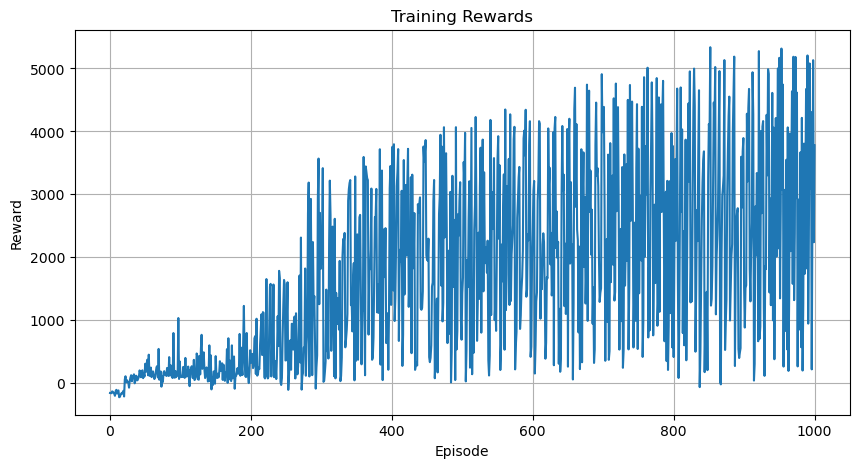

In [ ]:
# Start training
print(f"Starting BipedalWalker training on {device}...")

# Configurable Hyperparameters
MAX_EPISODES = 2000 # Increased to allow more training time
UPDATES_PER_STEP = 2  # Higher gradient updates per step for sample efficiency
NUM_ENVS = 4 # Number of parallel environments (vectorized)
START_STEPS = 20000 # Increased exploration
RENDER_FREQ = 50 # Render every 50 episodes

rewards, trained_agent = train_agent(
    max_episodes=MAX_EPISODES, 
    device=device, 
    updates_per_step=UPDATES_PER_STEP,
    start_steps=START_STEPS,
    num_envs=NUM_ENVS,
    render_freq=RENDER_FREQ
) 
print("Training completed!")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title("Training Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

## Video Recording and Evaluation

After training, we can record a video of the agent's performance to visually verify its walking ability. This is required for the application.

In [ ]:
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import glob
import os

def load_checkpoint(checkpoint_path, state_dim, action_dim, device="cpu", learning_rate=3e-4):
    """Load a trained agent from a checkpoint."""
    agent = SACAgent(state_dim, action_dim, device=device, learning_rate=learning_rate)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    # Load with strict=False to handle architecture changes (old log_std param vs new log_std_linear layer)
    agent.actor.load_state_dict(checkpoint['actor_state_dict'], strict=False)
    agent.critic1.load_state_dict(checkpoint['critic1_state_dict'], strict=False)
    agent.critic2.load_state_dict(checkpoint['critic2_state_dict'], strict=False)

    print(f"Loaded checkpoint from: {checkpoint_path}")
    return agent

def record_video(agent, env_name="BipedalWalker-v3", filename="bipedal_walker", device="cpu"):
    # Create environment with render mode
    env = gym.make(env_name, render_mode="rgb_array")

    # Wrap environment to record video
    # We force record the first episode
    video_folder = "videos"
    os.makedirs(video_folder, exist_ok=True)
    env = RecordVideo(env, video_folder=video_folder, name_prefix=filename, episode_trigger=lambda x: True)

    state, _ = env.reset()
    done = False
    truncated = False
    total_reward = 0

    while not (done or truncated):
        # Use deterministic policy for evaluation
        action = agent.select_action(state, deterministic=True)

        # Ensure action is 1D if it comes back as 2D batch (handle legacy/stale agent instances)
        if isinstance(action, np.ndarray) and action.ndim > 1:
             action = action.flatten()

        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward

    env.close()
    print(f"Evaluation Run - Total Reward: {total_reward:.2f}")

    # Find the video file
    mp4_files = glob.glob(f"{video_folder}/{filename}-episode-0.mp4")
    if mp4_files:
        print(f"Video saved to {mp4_files[0]}")
        return mp4_files[0]
    return None

# Record and display video from latest checkpoint
# Find the latest checkpoint in the logs directory
log_dirs = glob.glob("logs/run_*")
if log_dirs:
    latest_log_dir = max(log_dirs, key=os.path.getctime)
    checkpoints = glob.glob(f"{latest_log_dir}/checkpoint_ep*.pth")

    if checkpoints:
        # Select by highest episode number rather than filesystem time
        def _ep_num(path):
            name = os.path.basename(path)
            try:
                return int(name.split("checkpoint_ep")[1].split(".pth")[0])
            except Exception:
                return -1

        latest_checkpoint = max(checkpoints, key=_ep_num)
        print(f"Loading agent from highest-episode checkpoint: {latest_checkpoint}")

        # Create a fresh agent and load the checkpoint
        env_temp = gym.make("BipedalWalker-v3")
        state_dim = env_temp.observation_space.shape[0]
        action_dim = env_temp.action_space.shape[0]
        env_temp.close()

        checkpoint_agent = load_checkpoint(latest_checkpoint, state_dim, action_dim, device=device)

        # Use log directory name as video filename
        log_dir_name = os.path.basename(latest_log_dir)

        # Record video with the loaded agent
        video_path = record_video(checkpoint_agent, filename=log_dir_name, device=device)
        if video_path:
            display(Video(video_path, embed=True, html_attributes="controls autoplay loop"))
    else:
        print("No checkpoints found in logs directory")
else:
    print("No log directories found. Train the agent first.")

Loading agent from: logs/run_20251225_202943_ec860c_on_colab_32_parallel/checkpoint_ep710.pth
Loaded checkpoint from: logs/run_20251225_202943_ec860c_on_colab_32_parallel/checkpoint_ep710.pth
Evaluation Run - Total Reward: 112.04
Video saved to videos/run_20251225_202943_ec860c_on_colab_32_parallel-episode-0.mp4


In [ ]:
def run_ablation_study(device="cpu"):
    # Compare different learning rates
    learning_rates = [1e-3, 3e-4, 1e-4]
    results = {}
    
    print("Starting Ablation Study on Learning Rates...")
    
    # Create a timestamped directory for the ablation study
    study_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    study_dir = os.path.join("logs", f"ablation_{study_timestamp}")
    os.makedirs(study_dir, exist_ok=True)
    print(f"Ablation results will be saved to: {study_dir}")
    
    for lr in learning_rates:
        print(f"\nTesting Learning Rate: {lr}")
        # Run training for fewer episodes for ablation study to save time, or full duration if desired
        # Using 500 episodes for ablation study demonstration
        ablation_episodes = 500 
        
        # Use a separate subfolder for each learning rate to avoid file conflicts
        # and to keep logs organized
        run_log_dir = os.path.join(study_dir, f"lr_{lr}")
        
        # render_freq=0 disables rendering for speed
        rewards, _ = train_agent(max_episodes=ablation_episodes, device=device, learning_rate=lr, log_dir=run_log_dir, render_freq=0)
        results[f"lr_{lr}"] = rewards
        
        # Save intermediate result in the study directory
        np.save(os.path.join(study_dir, f"ablation_rewards_lr_{lr}.npy"), rewards)
    
    print("Ablation study completed. Plotting results...")
    
    # Plot results
    plt.figure(figsize=(12, 6))
    for name, rewards in results.items():
        # Smooth rewards for better visualization
        window = 10
        smoothed_rewards = [np.mean(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
        plt.plot(smoothed_rewards, label=name)
        
    plt.title("Ablation Study: Learning Rates (Smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the ablation study
run_ablation_study(device=device)

# AISF Application Writeup

## Applicant Information
- **Name**: [Your Name]
- **Email**: [Your Email]

## Prior Experience
*Briefly describe any prior experience you have in RL, Deep Learning, and coding.*

## Time Breakdown
*Total hours spent: X hours*
- Research/Reading: X hours
- Coding: X hours
- Training/Tuning: X hours
- Writing: X hours

## Compute Resources
*Describe the hardware used.*
- CPU: [Number of threads, Model]
- GPU: [Model] (if applicable)

## Techniques Used
*List the techniques used (e.g., SAC, Double Q-Learning, Soft Updates) and justify why they are suitable for this environment.*

## Ablation Studies
*Summarize the results of your ablation studies here. What hyperparameters did you tweak? What was the impact?*

## Discussion of Issues
*Discuss challenges encountered, ideas that didn't work, and how you pivoted.*

## Conclusion
*Summarize what worked well and what could be improved with more time.*

## Citations
- [Haarnoja, T., et al. "Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." arXiv preprint arXiv:1801.01290 (2018).](https://arxiv.org/abs/1801.01290)
- [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/)